In [1]:
import volta

In this example file a group of networks is clustered into groups based on different similarities of their nodes, edges & structural properties.
To run this pipeline it is recommended to have ~8GB of memory available on your system.

# Load & Pre-Process Networks

The first step of the pipeline consists in loading the chosen data set.
You can store your networks in any common format, however the VOLTA package requires that the networks are provided as NetworkX Graph objects (refer to its documentation for detailed instructions). Moreover, the networks should be weighted: if you have an unweighted network, then assign all edges the same edge weight. The package assumes "weight" to be the default edge weight label, but this can be set when needed.

An example on how to pre-process a network, stored as an edgelist, is provided below. Different loading and storing examples are provided in the "import and export of networks" jupyter notebook. 

In [2]:
#location where the raw data files are stored, it is set to run from the installation folder
#- if applicable please CHANGE or CHANGE to the location of your networks

graph_location = "../networks/edgelists/"


In [3]:
#location where output should be saved
#Please set location
location = ""


In [4]:
import glob
import pandas as pd
import networkx as nx
import numpy as np
import os

In [5]:

labels = []
networks_graphs = []

print("load networks")
#gets all files located in the specified folder that end on .edgelist
#CHANGE the ending if your files end differently
for path in glob.glob(graph_location +"*.edgelist"):
    
    #you can specify that only part of the file name should be used as network name for later identification
    name =  path.split(os.path.sep)[-1].replace(".rds.edgelist", "")

     
    #read the edgelist file as a dataframe
    fh = pd.read_csv(path, sep="\t")
    #convert it into a NetworkX graph G and specify the column names of the node pairs
    G=nx.from_pandas_edgelist(fh, "V1", "V2")
    
    #if you have an unweighted network assign all edges the same edge weight - here a value of 1 is assigned
    for u, v, d in G.edges(data=True):
        d['weight'] = 1
        
    
    #save the graph objects to a list (only suitable if small networks are processed)
    #this is the main objects used for the examples below, which contains all networks
    networks_graphs.append(G)
    labels.append(name)
   

    

    print("loaded", name)

load networks
loaded dasatinib_A549
loaded dasatinib_BT20
loaded dasatinib_PC3
loaded dasatinib_HCC515
loaded dasatinib_HEPG2
loaded dasatinib_NPC
loaded dasatinib_MCF7
loaded dasatinib_HUVEC
loaded dasatinib_HS578T
loaded dasatinib_SKL
loaded dasatinib_NEU
loaded dasatinib_HT29
loaded dasatinib_SKBR3
loaded dasatinib_HA1E
loaded dasatinib_CD34
loaded dasatinib_HME1
loaded dasatinib_A375
loaded dasatinib_ASC
loaded dasatinib_MDAMB231
loaded mitoxantrone_A549
loaded dasatinib_MCF10A


The networkX graph object is converted into a list of lists format

In [6]:
networks = volta.get_node_similarity.preprocess_graph(networks_graphs, attribute="weight")

Optional: If multiple networks are provided, get the union of nodes between them in order to ensure that all node names are mapped to the correct IDs (if this transformation is applied)

In [7]:
network_lists, mapping = volta.get_node_similarity.preprocess_node_list(networks)

In [8]:
import pickle

In [9]:
#save the mapping for later

with open(location + "node_id_mapping.pckl", "wb") as f:
    pickle.dump(mapping, f, protocol=4)

# Node Similarity

In this example, we will show how to compute node properties, such as: degree centrality, betweenness centrality and closeness centrality, of the shared nodes between the networks (when you have networks with different nodes). 

In the example the volta.get_node_similarity function is used. It is a wrapper function - if you are only interested in one output you can call the underlying functions directly, for this please refer to the documentation

Outputs:
sorted_nodes contains the node ids sorted after the selected properties as well as the mean and median ranking

shared_nodes contains for each nodes in how many networks it occures (this may be useful for networks that do not have the same nodes)

binary contains the shared nodes in a binary representation

centrality_values contains the selected properties for each node


Notes:
You can select which parameters are the most suitable for you analysis. Make sure to remove the asynchrone option when running in jupyter notebooks. 



In [9]:
sorted_nodes, shared_nodes, binary, centrality_values = volta.get_node_similarity.sort_list_and_get_shared(network_lists, mapping, networks_graphs, labels, degree_centrality=True, closeness_centrality=True, betweenness=True, degree=False, in_async=False)

dasatinib_A549
dasatinib_BT20
dasatinib_PC3
dasatinib_HCC515
dasatinib_HEPG2
dasatinib_NPC
dasatinib_MCF7
dasatinib_HUVEC
dasatinib_HS578T
dasatinib_SKL
dasatinib_NEU
dasatinib_HT29
dasatinib_SKBR3
dasatinib_HA1E
dasatinib_CD34
dasatinib_HME1
dasatinib_A375
dasatinib_ASC
dasatinib_MDAMB231
mitoxantrone_A549
dasatinib_MCF10A
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
average position is calculated
1
2
3
av

In order to calculate multiple distances between the networks, the volta.get_node_similarity.estimate_similarities_nodes function can be used. 

Similarly, this is a wrapper function calling different distance measures: if you are interested in only one distance you can use the single function directly. If not all values are needed to be calculated you can use the individual functions called in the wrapper. For this refer to the documentation.

This wrapper returns distance/similarity matrices of jaccard similarity, jaccard distance, percentage of shared nodes, kendall rank correlation of degree centrality, closeness centrality and betweenness centrality and mean / median ranking as well as the corresponding p-values for the top and bottom kendall_x nodes (or as here all nodes), hamming distance and SMC similarity.

In [11]:
combined_res =volta.get_node_similarity.estimate_similarities_nodes(network_lists, sorted_nodes, binary,  kendall_x=len(mapping), is_file=False, in_async=False)

kendall top
check if kendall x is small enough 
(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(0, 10)
(0, 11)
(0, 12)
(0, 13)
(0, 14)
(0, 15)
(0, 16)
(0, 17)
(0, 18)
(0, 19)
(0, 20)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(1, 11)
(1, 12)
(1, 13)
(1, 14)
(1, 15)
(1, 16)
(1, 17)
(1, 18)
(1, 19)
(1, 20)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)
(2, 11)
(2, 12)
(2, 13)
(2, 14)
(2, 15)
(2, 16)
(2, 17)
(2, 18)
(2, 19)
(2, 20)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(3, 10)
(3, 11)
(3, 12)
(3, 13)
(3, 14)
(3, 15)
(3, 16)
(3, 17)
(3, 18)
(3, 19)
(3, 20)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(4, 9)
(4, 10)
(4, 11)
(4, 12)
(4, 13)
(4, 14)
(4, 15)
(4, 16)
(4, 17)
(4, 18)
(4, 19)
(4, 20)
(5, 0)
(5, 1)
(5, 2)
(5, 3)
(5, 4)
(5, 5)
(5, 6)
(5, 7)
(5, 8)
(5, 9)
(5, 10)
(5, 11)
(5, 12)
(5, 13)
(5, 14)
(5, 15)
(5, 16)
(5, 17)
(5, 18)
(5, 19)
(5, 20)
(6, 

(14, 16)
(14, 17)
(14, 18)
(14, 19)
(14, 20)
(15, 0)
(15, 1)
(15, 2)
(15, 3)
(15, 4)
(15, 5)
(15, 6)
(15, 7)
(15, 8)
(15, 9)
(15, 10)
(15, 11)
(15, 12)
(15, 13)
(15, 14)
(15, 15)
(15, 16)
(15, 17)
(15, 18)
(15, 19)
(15, 20)
(16, 0)
(16, 1)
(16, 2)
(16, 3)
(16, 4)
(16, 5)
(16, 6)
(16, 7)
(16, 8)
(16, 9)
(16, 10)
(16, 11)
(16, 12)
(16, 13)
(16, 14)
(16, 15)
(16, 16)
(16, 17)
(16, 18)
(16, 19)
(16, 20)
(17, 0)
(17, 1)
(17, 2)
(17, 3)
(17, 4)
(17, 5)
(17, 6)
(17, 7)
(17, 8)
(17, 9)
(17, 10)
(17, 11)
(17, 12)
(17, 13)
(17, 14)
(17, 15)
(17, 16)
(17, 17)
(17, 18)
(17, 19)
(17, 20)
(18, 0)
(18, 1)
(18, 2)
(18, 3)
(18, 4)
(18, 5)
(18, 6)
(18, 7)
(18, 8)
(18, 9)
(18, 10)
(18, 11)
(18, 12)
(18, 13)
(18, 14)
(18, 15)
(18, 16)
(18, 17)
(18, 18)
(18, 19)
(18, 20)
(19, 0)
(19, 1)
(19, 2)
(19, 3)
(19, 4)
(19, 5)
(19, 6)
(19, 7)
(19, 8)
(19, 9)
(19, 10)
(19, 11)
(19, 12)
(19, 13)
(19, 14)
(19, 15)
(19, 16)
(19, 17)
(19, 18)
(19, 19)
(19, 20)
(20, 0)
(20, 1)
(20, 2)
(20, 3)
(20, 4)
(20, 5)
(20, 6)
(20,

(6, 9)
(6, 10)
(6, 11)
(6, 12)
(6, 13)
(6, 14)
(6, 15)
(6, 16)
(6, 17)
(6, 18)
(6, 19)
(6, 20)
(7, 0)
(7, 1)
(7, 2)
(7, 3)
(7, 4)
(7, 5)
(7, 6)
(7, 7)
(7, 8)
(7, 9)
(7, 10)
(7, 11)
(7, 12)
(7, 13)
(7, 14)
(7, 15)
(7, 16)
(7, 17)
(7, 18)
(7, 19)
(7, 20)
(8, 0)
(8, 1)
(8, 2)
(8, 3)
(8, 4)
(8, 5)
(8, 6)
(8, 7)
(8, 8)
(8, 9)
(8, 10)
(8, 11)
(8, 12)
(8, 13)
(8, 14)
(8, 15)
(8, 16)
(8, 17)
(8, 18)
(8, 19)
(8, 20)
(9, 0)
(9, 1)
(9, 2)
(9, 3)
(9, 4)
(9, 5)
(9, 6)
(9, 7)
(9, 8)
(9, 9)
(9, 10)
(9, 11)
(9, 12)
(9, 13)
(9, 14)
(9, 15)
(9, 16)
(9, 17)
(9, 18)
(9, 19)
(9, 20)
(10, 0)
(10, 1)
(10, 2)
(10, 3)
(10, 4)
(10, 5)
(10, 6)
(10, 7)
(10, 8)
(10, 9)
(10, 10)
(10, 11)
(10, 12)
(10, 13)
(10, 14)
(10, 15)
(10, 16)
(10, 17)
(10, 18)
(10, 19)
(10, 20)
(11, 0)
(11, 1)
(11, 2)
(11, 3)
(11, 4)
(11, 5)
(11, 6)
(11, 7)
(11, 8)
(11, 9)
(11, 10)
(11, 11)
(11, 12)
(11, 13)
(11, 14)
(11, 15)
(11, 16)
(11, 17)
(11, 18)
(11, 19)
(11, 20)
(12, 0)
(12, 1)
(12, 2)
(12, 3)
(12, 4)
(12, 5)
(12, 6)
(12, 7)
(12, 8)
(

(0, 7)
(0, 8)
(0, 9)
(0, 10)
(0, 11)
(0, 12)
(0, 13)
(0, 14)
(0, 15)
(0, 16)
(0, 17)
(0, 18)
(0, 19)
(0, 20)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(1, 11)
(1, 12)
(1, 13)
(1, 14)
(1, 15)
(1, 16)
(1, 17)
(1, 18)
(1, 19)
(1, 20)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)
(2, 11)
(2, 12)
(2, 13)
(2, 14)
(2, 15)
(2, 16)
(2, 17)
(2, 18)
(2, 19)
(2, 20)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(3, 10)
(3, 11)
(3, 12)
(3, 13)
(3, 14)
(3, 15)
(3, 16)
(3, 17)
(3, 18)
(3, 19)
(3, 20)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(4, 9)
(4, 10)
(4, 11)
(4, 12)
(4, 13)
(4, 14)
(4, 15)
(4, 16)
(4, 17)
(4, 18)
(4, 19)
(4, 20)
(5, 0)
(5, 1)
(5, 2)
(5, 3)
(5, 4)
(5, 5)
(5, 6)
(5, 7)
(5, 8)
(5, 9)
(5, 10)
(5, 11)
(5, 12)
(5, 13)
(5, 14)
(5, 15)
(5, 16)
(5, 17)
(5, 18)
(5, 19)
(5, 20)
(6, 0)
(6, 1)
(6, 2)
(6, 3)
(6, 4)
(6, 5)
(6, 6)
(6, 7)
(6, 8)
(6, 9)
(6, 10)
(6, 11)
(6, 12)
(6, 13)

(16, 20)
(17, 0)
(17, 1)
(17, 2)
(17, 3)
(17, 4)
(17, 5)
(17, 6)
(17, 7)
(17, 8)
(17, 9)
(17, 10)
(17, 11)
(17, 12)
(17, 13)
(17, 14)
(17, 15)
(17, 16)
(17, 17)
(17, 18)
(17, 19)
(17, 20)
(18, 0)
(18, 1)
(18, 2)
(18, 3)
(18, 4)
(18, 5)
(18, 6)
(18, 7)
(18, 8)
(18, 9)
(18, 10)
(18, 11)
(18, 12)
(18, 13)
(18, 14)
(18, 15)
(18, 16)
(18, 17)
(18, 18)
(18, 19)
(18, 20)
(19, 0)
(19, 1)
(19, 2)
(19, 3)
(19, 4)
(19, 5)
(19, 6)
(19, 7)
(19, 8)
(19, 9)
(19, 10)
(19, 11)
(19, 12)
(19, 13)
(19, 14)
(19, 15)
(19, 16)
(19, 17)
(19, 18)
(19, 19)
(19, 20)
(20, 0)
(20, 1)
(20, 2)
(20, 3)
(20, 4)
(20, 5)
(20, 6)
(20, 7)
(20, 8)
(20, 9)
(20, 10)
(20, 11)
(20, 12)
(20, 13)
(20, 14)
(20, 15)
(20, 16)
(20, 17)
(20, 18)
(20, 19)
(20, 20)


This distances can be merged into a single distance matrix or used individually.

Since all networks have the same nodes, we will only use the average rank correlation matrix previously computed, but transform it into a distance - the correlation value c is transformed to a distance with (1-c)/2. The distances will then be plotted as a heatmap. 

In [12]:
import numpy as np

In [13]:
mean_dist = combined_res["kendall_avg_top"].copy()

for index, x in np.ndenumerate(mean_dist):
    d = (1-x)/2
    
    mean_dist[index[0]][index[1]] = d
    
    if index[0] == index[1]:
        mean_dist[index[0]][index[1]] = 0

In [14]:
mean_dist_nodes = mean_dist.copy()

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

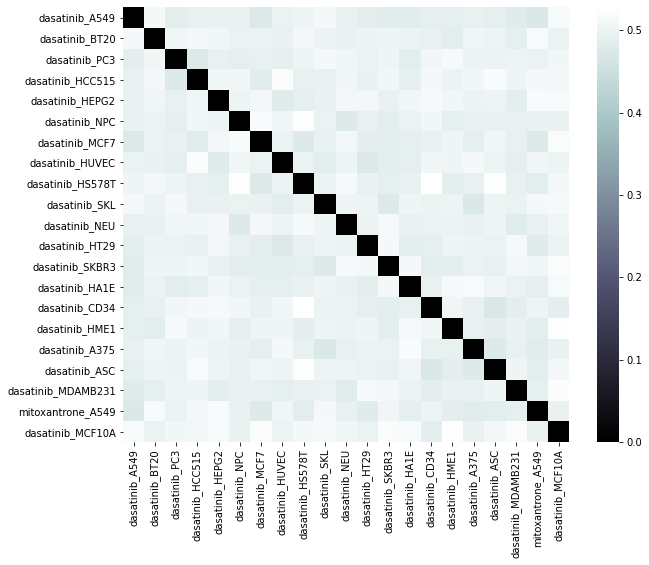

In [16]:
f = volta.plotting.plot_heatmap(mean_dist, xlabels=labels, ylabels = labels)

# Edge Similarity

In this second example, we will use the same preprocessed networks to compute edge similarity. 

Since the networks used here (when using the example networks) were originally unweighted, we assigned each edge its edge betweenness value as weight and compared the networks based on this value for shared edges. If you are working with weighted networks you can either use the original edge weights or estimate their weighted/ unweighted betweenness values. 

In [17]:
#sort edges after edge betweenness and assign to the graph objects
bet = []
graphs_with_betweenness = []
for net in networks_graphs:
    edges_betweenness = nx.edge_betweenness_centrality(net)
    bet.append(edges_betweenness)
    #write as new attribute to graph
    temp = nx.set_edge_attributes(net, edges_betweenness, "betweenness")
    

We need to convert the networks again into the list of lists format, since this time the betweeness values will be used and assign each edge an id. 

In [18]:
networks = volta.get_edge_similarity.preprocess_graph(networks_graphs, attribute="betweenness")



network_lists, mapping = volta.get_edge_similarity.preprocess_edge_list(networks)

#save mapping for later
with open(location + "edge_id_mapping.pckl", "wb") as f:
    pickle.dump(mapping, f, protocol=4)

Sort edges after betweenness values are assigned as weights and estimate for each edge in which network it appears. Here the volta.get_edge_similarity.sort_list_and_get_shared function is used.

In [19]:
sorted_networks, shared_edges, binary = volta.get_edge_similarity.sort_list_and_get_shared(networks, mapping, network_lists, labels, in_async=False)

dasatinib_A549
dasatinib_BT20
dasatinib_PC3
dasatinib_HCC515
dasatinib_HEPG2
dasatinib_NPC
dasatinib_MCF7
dasatinib_HUVEC
dasatinib_HS578T
dasatinib_SKL
dasatinib_NEU
dasatinib_HT29
dasatinib_SKBR3
dasatinib_HA1E
dasatinib_CD34
dasatinib_HME1
dasatinib_A375
dasatinib_ASC
dasatinib_MDAMB231
mitoxantrone_A549
dasatinib_MCF10A


You can now compute distances/ similarities between the networks based on their similarity in edges.

The volta.get_edge_similarity.estimate_similarities_edges wrapper function returns jaccard similarity, jaccard distance, kendall rank coefficient for kendall_x top and bottom edges (here ranked after betweenness), hamming distance and SMC similarity. As before, if only specific distances are needed the individual functions can be called, please refer to the documentation for this.

In [20]:
combined_res = volta.get_edge_similarity.estimate_similarities_edges(network_lists, sorted_networks, binary,  kendall_x=100, is_file=False, in_async=False)

check if kendall x is small enough 
(0, 0)
(0, 1)
input lists have different length
(0, 2)
input lists have different length
(0, 3)
input lists have different length
(0, 4)
input lists have different length
(0, 5)
input lists have different length
(0, 6)
input lists have different length
(0, 7)
input lists have different length
(0, 8)
input lists have different length
(0, 9)
input lists have different length
(0, 10)
input lists have different length
(0, 11)
input lists have different length
(0, 12)
input lists have different length
(0, 13)
input lists have different length
(0, 14)
input lists have different length
(0, 15)
input lists have different length
(0, 16)
input lists have different length
(0, 17)
input lists have different length
(0, 18)
input lists have different length
(0, 19)
input lists have different length
(0, 20)
input lists have different length
(1, 0)
(1, 1)
(1, 2)
input lists have different length
(1, 3)
input lists have different length
(1, 4)
input lists have differ

(15, 19)
input lists have different length
(15, 20)
input lists have different length
(16, 0)
(16, 1)
(16, 2)
(16, 3)
(16, 4)
(16, 5)
(16, 6)
(16, 7)
(16, 8)
(16, 9)
(16, 10)
(16, 11)
(16, 12)
(16, 13)
(16, 14)
(16, 15)
(16, 16)
(16, 17)
input lists have different length
(16, 18)
input lists have different length
(16, 19)
input lists have different length
(16, 20)
input lists have different length
(17, 0)
(17, 1)
(17, 2)
(17, 3)
(17, 4)
(17, 5)
(17, 6)
(17, 7)
(17, 8)
(17, 9)
(17, 10)
(17, 11)
(17, 12)
(17, 13)
(17, 14)
(17, 15)
(17, 16)
(17, 17)
(17, 18)
input lists have different length
(17, 19)
input lists have different length
(17, 20)
input lists have different length
(18, 0)
(18, 1)
(18, 2)
(18, 3)
(18, 4)
(18, 5)
(18, 6)
(18, 7)
(18, 8)
(18, 9)
(18, 10)
(18, 11)
(18, 12)
(18, 13)
(18, 14)
(18, 15)
(18, 16)
(18, 17)
(18, 18)
(18, 19)
input lists have different length
(18, 20)
input lists have different length
(19, 0)
(19, 1)
(19, 2)
(19, 3)
(19, 4)
(19, 5)
(19, 6)
(19, 7)
(19, 8)

(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(0, 10)
(0, 11)
(0, 12)
(0, 13)
(0, 14)
(0, 15)
(0, 16)
(0, 17)
(0, 18)
(0, 19)
(0, 20)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(1, 11)
(1, 12)
(1, 13)
(1, 14)
(1, 15)
(1, 16)
(1, 17)
(1, 18)
(1, 19)
(1, 20)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)
(2, 11)
(2, 12)
(2, 13)
(2, 14)
(2, 15)
(2, 16)
(2, 17)
(2, 18)
(2, 19)
(2, 20)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(3, 10)
(3, 11)
(3, 12)
(3, 13)
(3, 14)
(3, 15)
(3, 16)
(3, 17)
(3, 18)
(3, 19)
(3, 20)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(4, 9)
(4, 10)
(4, 11)
(4, 12)
(4, 13)
(4, 14)
(4, 15)
(4, 16)
(4, 17)
(4, 18)
(4, 19)
(4, 20)
(5, 0)
(5, 1)
(5, 2)
(5, 3)
(5, 4)
(5, 5)
(5, 6)
(5, 7)
(5, 8)
(5, 9)
(5, 10)
(5, 11)
(5, 12)
(5, 13)
(5, 14)
(5, 15)
(5, 16)
(5, 17)
(5, 18)
(5, 19)
(5, 20)
(6, 0)
(6, 1)
(6, 2)
(6, 3)
(6, 4)
(6, 5)
(6, 6)
(6, 7)
(6, 8)
(6, 9)
(6,

Where applicable the similarities are converted into a distance by taking 1-x (other conversions can also be used). The conversion is required since the clustering algorithms provided take distance matrices as input. Additional the individual similarity/ distance metrics are combined for the later clustering analysis, which is optional.

In [21]:
smc_dist = combined_res["smc"].copy()

for index, x in np.ndenumerate(smc_dist):
    d = 1-x
    
    smc_dist[index[0]][index[1]] = d
    
    if index[0] == index[1]:
        smc_dist[index[0]][index[1]] = 0

In [22]:
p_dist = combined_res["percentage"].copy()

for index, x in np.ndenumerate(p_dist):
    d = 1-x
    
    p_dist[index[0]][index[1]] = d
    
    if index[0] == index[1]:
        p_dist[index[0]][index[1]] = 0

In [23]:
k_dist = combined_res["kendall_top"].copy()

for index, x in np.ndenumerate(k_dist):
    d = (1-x)/2
    
    k_dist[index[0]][index[1]] = d
    
    if index[0] == index[1]:
        k_dist[index[0]][index[1]] = 0

In [24]:
import statistics

In [25]:
#Optional: combine the individual matrices into a median distance matrix

mean_dist = volta.clustering.create_mean_distance_matrix([k_dist, combined_res["jd"], combined_res["hamming"], p_dist, smc_dist], set_diagonal = True)

In [26]:
mean_dist_edges = mean_dist.copy()

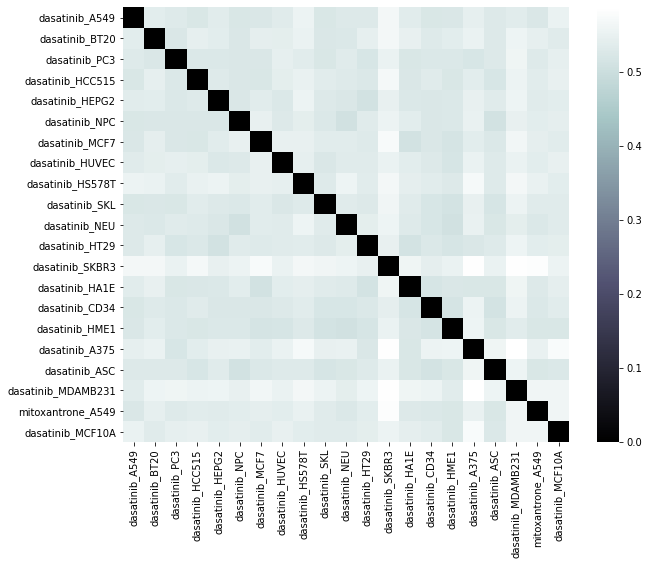

In [27]:
f = volta.plotting.plot_heatmap(mean_dist, xlabels=labels, ylabels = labels)

# Structural Similarity

In this example,we compute network distances based on graph structural properties

The volta.get_network_structural_vector.estimate_vector is a wrapper function that computes a vector based distance  on a few structural parameters implemented. This means that for each network a vector of parameters is estimated, such as network density, clustering and its diameter. The distance between the networks is then estimated based on the calculated individual vectors.

You can create your own vector by creating your own wrapper function, or call the corresponding functions. Please refer to the documentation for further information.
The vector used in this examples will contain data about the number of nodes & edges, network density, amount of missing edges, cycles, shortest path distributions, clustering coefficient, degree centrality/ closeness centrality and betweenness centrality distribution.

Note: The function requires a list of NetworkX graph objects as input. Some paramters can be expensive on large networks. Therefore it is advised to adjust the parameter selection based on your needs.



In [28]:
vectors = volta.get_network_structural_vector.estimate_vector(networks_graphs, edge_attribute="weight", is_file=False)

global
density
clustering
graph edges
cycles
shortest path distribution
cc
degree dist
cc dist
betweenness dist
[4, 5, 977, 10820, 0.02269409534036948, 0.19843699490692504, 97.73059046596305, 2.269409534036948, 9844, 19.361844778545308, 9.0, 22.125984501839454, 1.7087524664893101, 2.686150024221983, 2.8733563883339324, 3, 0.6809790986015235, -0.3064815114595464, 0.5158250650089595, 0.19843699490692504, 0.022694095340369484, 0.018442622950819672, 0.01601247723509953, 1.1469703698992353, 0.7470411125601788, 0.35019814519927017, 0.3523465703971119, 0.029122883768574487, -0.3733114300722847, -0.20010126761589042, 0.0019244106677198944, 0.0014748015908442906, 0.0015955889895656343, 1.4215620452241713, 2.2905868176071866]
global
graph size can only be estimated on connected graph, GCC will be used instead
density
clustering
graph edges
cycles
shortest path distribution
graph is not connected, GC will be used instead
cc
degree dist
cc dist
betweenness dist
[9, 16, 977, 10605, 0.02224314982297

density
clustering
graph edges
cycles
shortest path distribution
cc
degree dist
cc dist
betweenness dist
[5, 8, 977, 28388, 0.05954158766380858, 0.7266075187950926, 94.04584123361914, 5.954158766380858, 27412, 5.321209689187217, 3.0, 8.750846462153932, 4.59149016821716, 22.970919318411767, 3.69019485002551, 4, 1.215712419586702, -0.5009259519096803, -0.31612693729193486, 0.7266075187950926, 0.059541587663808584, 0.04815573770491804, 0.04045644718059392, 0.815330534495306, -0.3768999624828262, 0.2719651963036711, 0.27578411980785533, 0.01793510746589323, -0.7494807625073915, 0.33461830423505523, 0.0027630520896121517, 0.0016244160686065582, 0.003704273310523172, 3.126891131347161, 14.463739031523946]
global
density
clustering
graph edges
cycles
shortest path distribution
cc
degree dist
cc dist
betweenness dist
[4, 7, 977, 12405, 0.026018507643002165, 0.22681167422732515, 97.39814923569978, 2.6018507643002167, 11429, 18.89071659812757, 7, 24.085831427501013, 2.066576237862601, 4.39928406

Based on these vectors a distance matrix between the networks can be estimated.

volta.get_network_structural_vector.matrix_from_vector is a wrapper function which estimates the euclidean, canberra, correlation, cosine and jaccard distance based on the vectors.Here distance metrics that are not in a [0,1] range, have been normalized.

In [29]:
euclidean, canberra, correlation, cosine, jaccard = volta.get_network_structural_vector.matrix_from_vector(vectors, normalize=True)

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(0, 10)
(0, 11)
(0, 12)
(0, 13)
(0, 14)
(0, 15)
(0, 16)
(0, 17)
(0, 18)
(0, 19)
(0, 20)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(1, 11)
(1, 12)
(1, 13)
(1, 14)
(1, 15)
(1, 16)
(1, 17)
(1, 18)
(1, 19)
(1, 20)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)
(2, 11)
(2, 12)
(2, 13)
(2, 14)
(2, 15)
(2, 16)
(2, 17)
(2, 18)
(2, 19)
(2, 20)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(3, 10)
(3, 11)
(3, 12)
(3, 13)
(3, 14)
(3, 15)
(3, 16)
(3, 17)
(3, 18)
(3, 19)
(3, 20)
(4, 4)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(4, 9)
(4, 10)
(4, 11)
(4, 12)
(4, 13)
(4, 14)
(4, 15)
(4, 16)
(4, 17)
(4, 18)
(4, 19)
(4, 20)
(5, 5)
(5, 6)
(5, 7)
(5, 8)
(5, 9)
(5, 10)
(5, 11)
(5, 12)
(5, 13)
(5, 14)
(5, 15)
(5, 16)
(5, 17)
(5, 18)
(5, 19)
(5, 20)
(6, 6)
(6, 7)
(6, 8)
(6, 9)
(6, 10)
(6, 11)
(6, 12)
(6, 13)
(6, 14)
(6, 15)
(6, 16)
(6, 17)
(6, 18)
(6, 19)
(6, 20)
(7, 7)
(7, 8)
(7, 9)
(7, 10)
(7, 11)
(7, 

In [30]:
#Optional: merge the individual distances into a single distance matrix

mean_dist = volta.clustering.create_mean_distance_matrix([jaccard, euclidean, canberra, cosine], set_diagonal = True)

In [31]:
mean_dist_structural = mean_dist.copy()

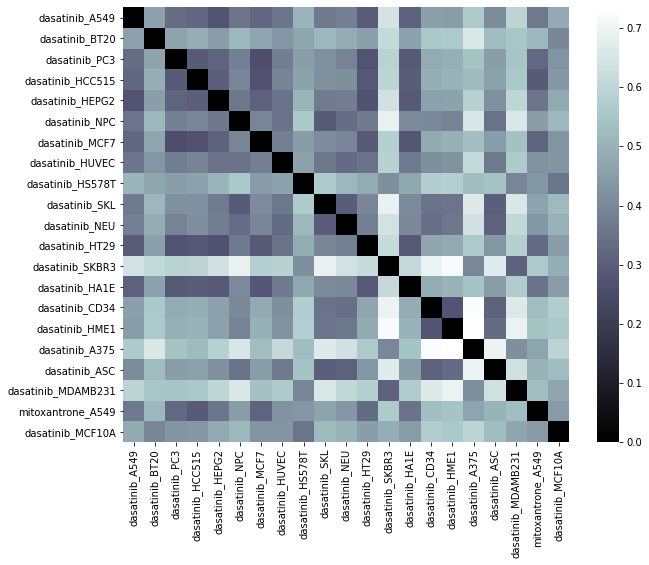

In [32]:
f = volta.plotting.plot_heatmap(mean_dist, xlabels=labels, ylabels = labels)

# Random Walks

In this example, we will use the Random walks method to characterize the structural/connectivity similarities around a specific node in different networks. In this example we will answer to the question: "Are the same nodes also similarly connected?"

The volta.get_walk_distances.helper_walks function performs random walks based on different starting nodes. Later, walks between networks for the same starting node will be compared.

The here used networks have all the same nodes, so nodes can simply be set to the node object of one of the graphs.

E.g. nodes = networks_graphs[0].nodes()

If the networks have different nodes then you can select which nodes should be compared (e.g. the union of nodes or only their intersection). If a node does not exist in a network None is returned for that node.
To reduce computational power you can investigate only a subset of pre-selected nodes of interest.

The example below uses the union (all of the example networks have the same nodes).

In [33]:
nodes = []
for net in networks_graphs:
    for node in net.nodes():
        if node not in nodes:
            nodes.append(node)

In [34]:
#select a random set of nodes
import random
nodes = random.sample(nodes,50)

For each node in each network, 2 walks of size 3 per node are performed. A random sample of nodes is selected, if needed this can be run on all nodes. Number of nodes and number of walks/ length affect the computational complexity and memory usage. The parameters can be adjusted as needed. 
Edges can be selected probabilisticly based on their attributes or can be viewed equally.


In [35]:
performed_walks = volta.get_walk_distances.helper_walks(networks_graphs, nodes, labels, steps=3, number_of_walks=2, degree=False, probabilistic=False, weight ="weight")

walks for node  0 outof 50


Now we are estimating for each starting node how often surrounding nodes/ edges have been visit with respect to all the visited nodes/ edges. 
Note: Depending on your network sizes and selected nodes this can be quite memory intensive.

In [36]:
node_counts, edge_counts, nodes_frc, edges_frc = volta.get_walk_distances.helper_get_counts(labels, networks_graphs, performed_walks)

Now we want to estimate network similarities based on the visited nodes. For each network pair, kendall rank correlation is calculated (of the top 50 nodes)  for the same starting node. The mean correlation value of all same node pairs for a network pair is estimated and returned.

In [37]:
results_edges, results_nodes, results_edges_p, results_nodes_p = volta.get_walk_distances.helper_walk_sim(networks_graphs, performed_walks, nodes, labels, top=50, undirected=False, return_all = False, nodes_ranked=nodes_frc, edges_ranked=edges_frc)

Optional:The correlations can be converted into a distance (as required by the clustering algorithms). Here the transformation of distance d = (1-c)/2 for a centrality score c is used.

In [38]:
cor_nodes = results_nodes.copy()

for index, x in np.ndenumerate(cor_nodes):
    d = (1-x)/2
    
    cor_nodes[index[0]][index[1]] = d
    
    if index[0] == index[1]:
        cor_nodes[index[0]][index[1]] = 0

In [39]:
cor_edges = results_edges.copy()

for index, x in np.ndenumerate(cor_edges):
    d = (1-x)/2
    
    cor_edges[index[0]][index[1]] = d
    
    if index[0] == index[1]:
        cor_edges[index[0]][index[1]] = 0

In [40]:
mean_dist = volta.clustering.create_mean_distance_matrix([cor_nodes, cor_edges], set_diagonal = True)

In [41]:
mean_dist_walks = mean_dist.copy()

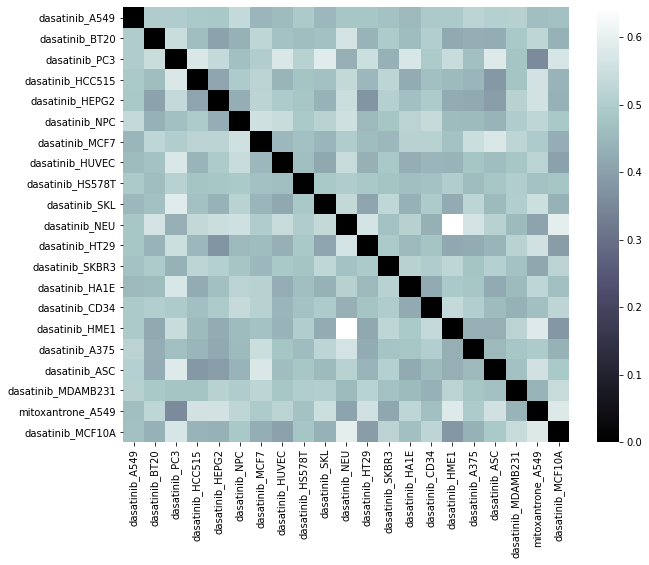

In [42]:
f = volta.plotting.plot_heatmap(mean_dist, xlabels=labels, ylabels = labels)

# Clustering

On each of the three median distance matrices calculated in the previous section clustering algorithms are run (the algorithms can also be run on the individual distance matrices if wished).
Here we use three different algorithms, but any algorithms more suited to your type of analysis can be applied. Please refer to the documentation for available algorithms.

Based on the three individual clusterings, a consensus clustering is created.
Each clustering algorithm is tuned based on a individually modifiable multiobjective function.

In [43]:
distances = [mean_dist_nodes, mean_dist_edges, mean_dist_structural, mean_dist_walks]
distances_name = ["nodes", "edges", "structural", "walks"]

In [44]:
clusterings = {}

for n in distances_name:
    clusterings[n] = []

Hierarchical clustering is run and best k value is estimated based on a multiobjective function, which focuses on maximizing the distance between clusters, minimizing distance within a cluster as well as having an even cluster size distribution
For the best k value the algorithm is run 10 times. One of the selected 3 algorithms has some randomness. In order to not bias towards one algorithm all are run the same amount of time. 

In [45]:
t = []
for i in range(2,len(labels)):
    t.append(i)
    
hierarchical = {}
for d in range(len(distances)):
    dist = distances[d]
    n = distances_name[d]
    maxs = 10000

    for i, k in enumerate(t):
    #for i, k in enumerate([2, 3]):




        cl_labels = volta.clustering.hierarchical_clustering(dist, n_clusters=k, linkage="complete")


        #print("obj 1")
        avg_score = volta.clustering.multiobjective(dist, cl_labels, min_number_clusters=None, max_number_clusters=None, min_cluster_size = None, max_cluster_size=None, local =True, bet=False, e=None, s=None, cluster_size_distribution = True)



        if avg_score < maxs:
            maxs = avg_score
            mk = k





    hierarchical[n] = k
    print(maxs, mk)
    
    print("creating clusterings for", n, "with k ", mk)
    
    cl_labels = volta.clustering.hierarchical_clustering(dist, n_clusters=mk, linkage="complete")

    #copy result 10 x since with the same parameters clustering is always the same
    for xx in range(10):  
        
        clusterings.setdefault(n, []).append(cl_labels)



1.4958345070416568 2
creating clusterings for nodes with k  2
1.5459508035191303 2
creating clusterings for edges with k  2
1.3562560938217976 4
creating clusterings for structural with k  4
1.436685840621963 4
creating clusterings for walks with k  4


Affinity propagation has no parameters to be set so does not need to be tuned, but it is also run ten times (or 10x the same clustering is appended) so that for the later consensus for each clustering algorithm the same number of clusterings are provided. 

In [47]:

for d in range(len(distances)):
    dist = distances[d]
    n = distances_name[d]
    
    cl_labels = volta.clustering.affinityPropagation_clustering(dist)

    #add copy of resutl 10 times to the clustering dict, since it always gives the same result
    for xx in range(10):
        clusterings.setdefault(n, []).append(cl_labels)

K Mediods is tuned on the same multiobjective function and for the best k the algorithm is run 10 times.

In [48]:
t = []
for i in range(2,len(labels)):
    t.append(i)
    
kmed = {}
for d in range(len(distances)):
    dist = distances[d]
    n = distances_name[d]
    maxs = 10000

    for i, k in enumerate(t):
    #for i, k in enumerate([2, 3]):




        cl_labels, mediods = volta.clustering.kmedoids_clustering(dist, n_clusters=k)


        #print("obj 1")
        avg_score = volta.clustering.multiobjective(dist, cl_labels, min_number_clusters=None, max_number_clusters=None, min_cluster_size = None, max_cluster_size=None, local =True, bet=False, e=None, s=None, cluster_size_distribution = True)



        if avg_score < maxs:
            maxs = avg_score
            mk = k





    kmed[n] = k
    print(maxs, mk)
    
    print("creating clusterings for", n, "with k ", mk)
    
    for xx in range(10):
    
    
        cl_labels, mediods = volta.clustering.kmedoids_clustering(dist, n_clusters=mk)
        clusterings.setdefault(n, []).append(np.array(cl_labels))



1.4900984923937526 4
creating clusterings for nodes with k  4
1.5297866870189842 2
creating clusterings for edges with k  2
1.3541213417326168 5
creating clusterings for structural with k  5
1.429469310009718 5
creating clusterings for walks with k  5


For each of the groups we create an individual consensus clustering in order to compare this later to the combined consensus clustering. 


#### Nodes

In [49]:
merged_clusterings = []


for c in clusterings["nodes"]:
        
        merged_clusterings.append(c.tolist())

In [50]:
consensus_nodes = volta.clustering.consensus_clustering(merged_clusterings, seed=1234, threshold="matrix", per_node=False, rep = 10)

matrix


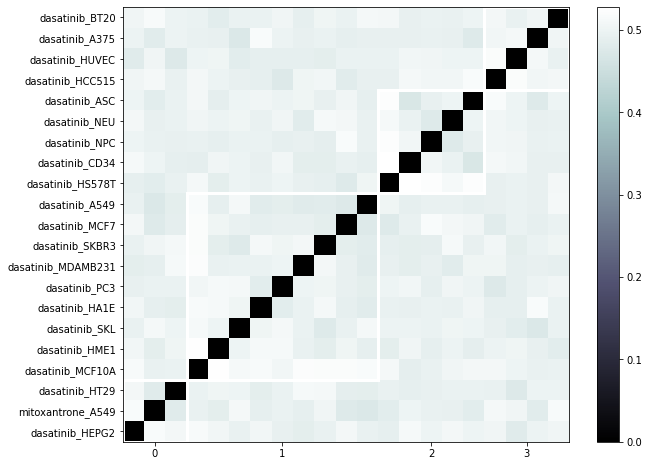

In [51]:
fig = volta.plotting.plot_clustering_heatmap(consensus_nodes, mean_dist_nodes, labels, cmap="bone")

#### Edges

In [52]:
merged_clusterings = []


for c in clusterings["edges"]:
        
        merged_clusterings.append(c.tolist())

In [53]:
consensus_edges = volta.clustering.consensus_clustering(merged_clusterings, seed=1234, threshold="matrix", per_node=False, rep = 10)

matrix


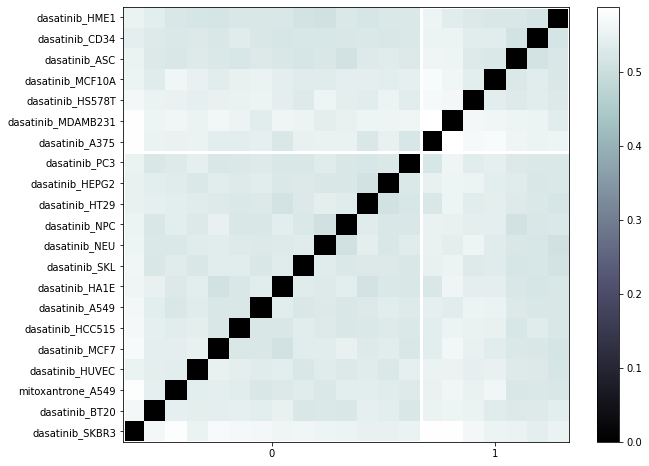

In [54]:
fig = volta.plotting.plot_clustering_heatmap(consensus_edges, mean_dist_edges, labels, cmap="bone")

#### Structural



In [55]:
merged_clusterings = []


for c in clusterings["structural"]:
        
        merged_clusterings.append(c.tolist())

In [56]:
consensus_structural = volta.clustering.consensus_clustering(merged_clusterings, seed=1234, threshold="matrix", per_node=False, rep = 10)

matrix


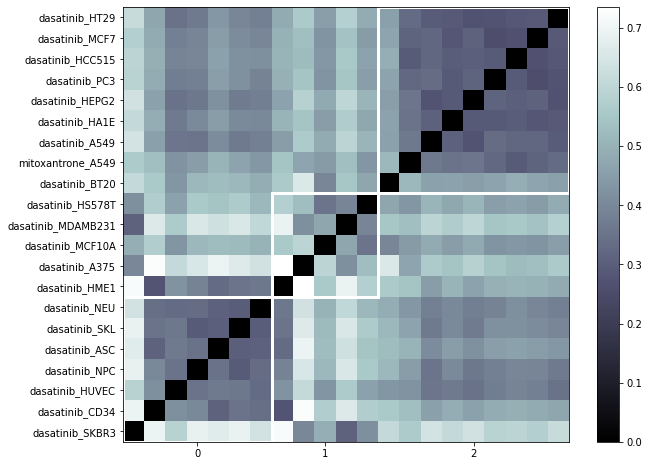

In [57]:
fig = volta.plotting.plot_clustering_heatmap(consensus_structural, mean_dist_structural, labels, cmap="bone")

#### Walks

In [58]:
merged_clusterings = []


for c in clusterings["walks"]:
        
        merged_clusterings.append(c.tolist())

In [59]:
consensus_walks = volta.clustering.consensus_clustering(merged_clusterings, seed=1234, threshold="matrix", per_node=False, rep = 10)

matrix


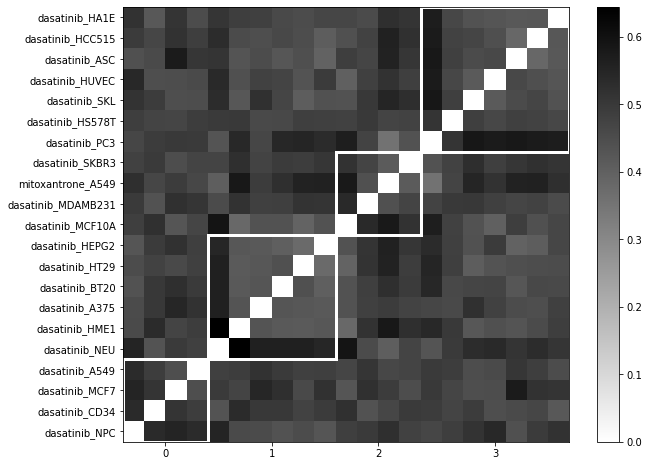

In [60]:
fig = volta.plotting.plot_clustering_heatmap(consensus_walks, mean_dist_walks, labels, cmap="binary")

We plot the agreement matrix, which shows for each pair in how many of the groups they have been clustered together.

In [61]:
consensus = [consensus_nodes, consensus_edges, consensus_structural, consensus_walks]

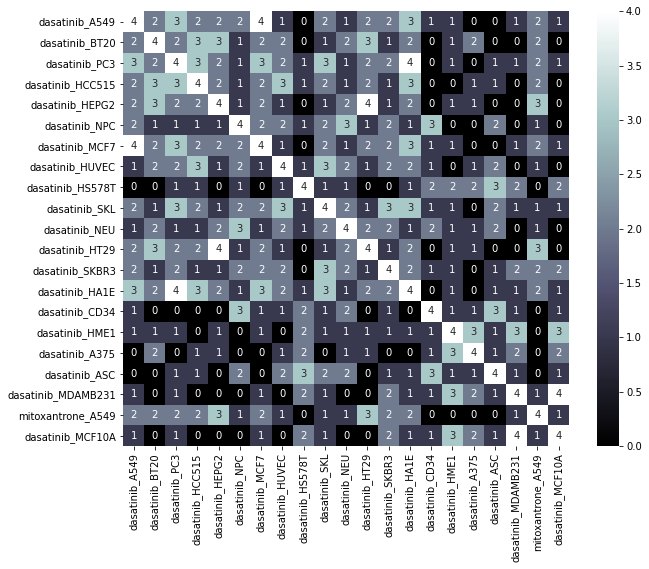

In [62]:
f, agg = volta.plotting.plot_agreement_matrix(consensus, xlabels=labels, ylabels=labels, annotation=True)

As we can see there are only 2 pairs that belong together on which all metrics agree on.

A Consensus Clustering is created from the individually performed clusterings. Please refer to the documentation for further information

In [63]:
merged_clusterings = []

for key in clusterings.keys():
    for c in clusterings[key]:
        
        merged_clusterings.append(c.tolist())

In [64]:
consensus = volta.clustering.consensus_clustering(merged_clusterings, seed=1234, threshold="matrix", per_node=False, rep = 10)

matrix
rerun


In [65]:
consensus

array([0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 2, 0, 1, 0, 2, 1, 1, 2, 1, 0, 1])

To show the complete clustering we estimate a mean combined distance matrix and plot the clustering on top of it.

In [66]:
mean_dist_combined = volta.clustering.create_median_distance_matrix(distances, set_diagonal = True)

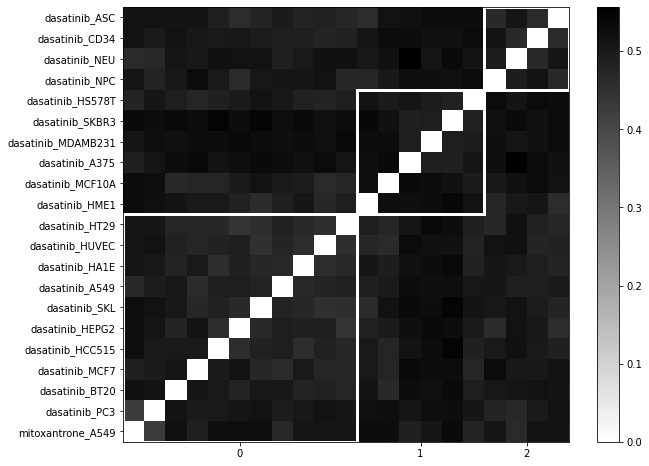

In [67]:
fig = volta.plotting.plot_clustering_heatmap(consensus, mean_dist_combined, labels, cmap="binary")

By tweaking the treshold or using another method, it is possible to tune the consensus based on your needs (you can also use the multiobjective function again to evaluate the consensus numerically)

In [68]:
max(consensus)+1

3

In [69]:
df = pd.DataFrame(list(zip(labels, consensus)), 
               columns =['CHEMICAL', 'CLUSTER'])

In [70]:
#view clustering
df

,CHEMICAL,CLUSTER
0,dasatinib_A549,0
1,dasatinib_BT20,0
2,dasatinib_PC3,0
3,dasatinib_HCC515,0
4,dasatinib_HEPG2,0
5,dasatinib_NPC,2
6,dasatinib_MCF7,0
7,dasatinib_HUVEC,0
8,dasatinib_HS578T,1
9,dasatinib_SKL,0


In [71]:
#save clustering for later. It can be used as input for the common subgraph pipeline

df.to_csv(location+"clustering_networks.csv", index=None)

In [72]:
all_consensus = [consensus_nodes, consensus_edges, consensus_structural, consensus_walks, consensus]

In [73]:
group_labels = ["nodes", "edges", "structural", "walks", "combined"]

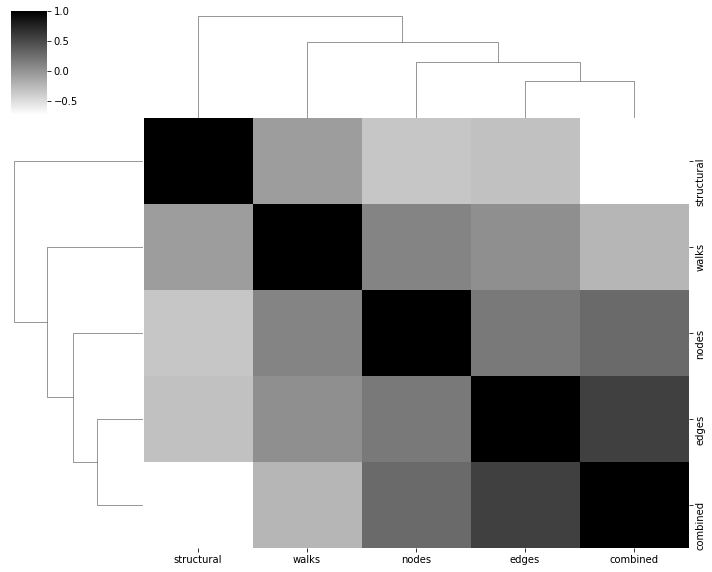

In [74]:
f, c = volta.plotting.plot_correlation_clusterings(all_consensus, xlabels=group_labels, ylabels=group_labels, size=(10,8), cmap="binary")